# **Viscous flow**
**Cecilia Rydefalk**

# **Abstract**

In the following report an example on a solution to the Stokes equation using FEniCS is presented. The velocity and pressure field in a 2D channel with an obstacle is studied. 

# **About the code**

In [25]:
"""This program is a lab report in the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# This file is an assignment in the course DD2365 Advanced Computation in Fluid Mechanics
# This report is based on a template provided by Johan Hoffman
# KTH Royal Institute of Technology, Stockholm, Sweden



'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

*Incompressible* flow can be described by the mass conservation equation
$$\quad \nabla \cdot u=0$$
together with the momentum equation, also known as the Navier-Stokes equation
$$\dot{u} + (u\cdot\nabla)u + \nabla p - \nu\Delta u =f .$$

One of the non-dimensional numbers used in fluid mechanics is the Reynolds number
$$\text{Re}=\frac{\rho UL}{\mu}$$
where $U$ is the velocity, $L$ is the characteristic length scale, $\rho$ is the density, and $\mu$ is the viscosity. A high $\text{Re}$ means that we have dominating inertia, while a low $\text{Re}$ says that the viscosity is dominating.

When $\text{Re}\rightarrow0$ and the viscous forces dominates over inertia, the Navier-Stokes equation can be reduced to the Stokes equation for steady $(\dot{u}=0)$ flow
$$\nabla p -\Delta u = f.$$

Using a mixed finite element method implemented in FEniCS, a solution and visualization of the 2D-flow field for creeping flow in a channel with an obstacle is presented.

The finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in V\times Q$ is sought. 



# **Method**

**Geometry setup**

*The* geometry of the problem is a 2D channel with a circular obstacle in the middle. The length of the channel is $x_{\text{max}}=4$ and the height is $y_{\text{max}}=4$. The circular obstacle is centered at $x=x_{\text{max}}/2$ and $y=y_{\text{max}}/2$ and has a radius of $r=0.2$.


**Mesh**

*The* base mesh is generated with a resolution of 32, i.e. the geometry is resolved with 32 elements across. The area around the circle is refined one level with a radius of 1. The meshes are shown in the figures.

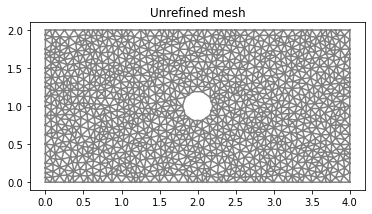

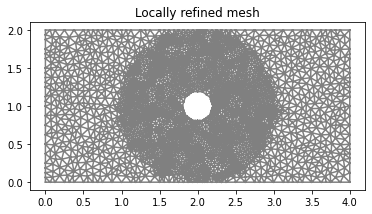

In [27]:
# Generate domain, resolution and mesh 
XMIN = 0.0; XMAX = 4
YMIN = 0.0; YMAX = 2
circlecenterpoint = Point(0.5*XMAX,0.5*YMAX)

domain = Rectangle(Point(0.0,0.0), Point(XMAX,YMAX)) - Circle(circlecenterpoint,0.2)

resolution = 32

unrefinedmesh = generate_mesh(domain, resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", unrefinedmesh, unrefinedmesh.topology().dim())
  for cell in cells(unrefinedmesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(circlecenterpoint) < 1.0:
        cell_marker[cell] = True
  mesh = refine(unrefinedmesh, cell_marker)

plt.figure()
plot(unrefinedmesh, title="Unrefined mesh")
plt.show()

plt.figure()
plot(mesh, title="Locally refined mesh")
plt.show()

**Finite element approximation spaces**

*For* the final element approximation first elements are defined, from there a function space is created and finally the trial and test functions are defined. To generate the mixed finite element (WE), two types of elements are created for the approximation spaces when solving Stokes equation, separating the second order approximation of velocity (VE) and first order approximation of pressure (QE).  

If the interpolation of the velocity and pressure are of equal order, i.e. set the third argument for both VE and QE to 1, the solutions becomes unstable which manifests as spurious oscillations in the pressure solution.




In [0]:
# Generate mixed finite element spaces. Elements for velocity (VE) and pressure (QE) 
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

**Define boundary conditions**

*The* flow in the channel is a steady flow (no time dependence and no inlet conditions) with a parabolic streamwise velocity profile due to the no-slip boundary conditions at the walls ($\overline{u}(y=0,y=y_{\text{max}}=0)=0$) and there is no cross stream velocity component at the inflow to the domain. 

The flow can be reversed by changing the inflow direction (in the residual further down).

In [0]:
# Inflow and outflow conditions: parabolic velocity profile at inflow (fully developed flow) and zero pressure at outflow
uinleft = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
uinright = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
pout = 0.0

# Left boundary (lb), right boundary (rb) and wall boundary (wb)
lb = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
rb = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 

wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())


# **Results**

**Define and solve variational problem**

*A* penalty formulation is used, with a penalty parameter $\gamma = C/h$, where the constant $C=0.001$ and $h$ is the local mesh size. 

If the interpolation of the velocity is set to the same order as the one for pressure the Brezzi-Pitkäranta stabilization can be used to counteract the effects

$$s(P,q)=B\int_{\Omega}h^{2}\nabla P\cdot\nabla q\; dx$$

where $B>0$ is a constant. This is added to the residual in the code below (BPstabilizer). 




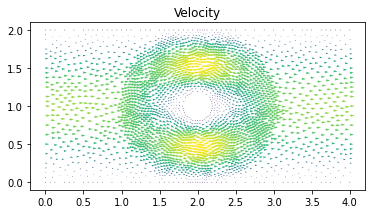

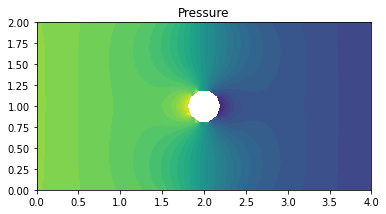

In [30]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
BPstabilizer = h*h*inner(grad(p), grad(q))*dx

#left to right flow
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(lb*inner(u - uinleft, v) + wb*inner(u, v))*ds - inner(f, v)*dx ) #+ BPstabilizer

#right to left flow
#residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
#            gamma*(rb*inner(u - uinright, v) + wb*inner(u, v))*ds - inner(f, v)*dx ) #+ BPstabilizer



# Solve algebraic system 
solve(residual == 0, w) 

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
plt.figure()
plot(u1, title="Velocity")

plt.figure()
plot(p1, title="Pressure")
        
plt.show()


# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

# **Discussion**

*A* Taylor-Hood mixed finite element method was implemented in FEniCS to solve the steady Stokes equations in 2D. The model problem was channel flow past a circular obstacle. 

The pressure driven flow goes from high pressure at the inflow boundary to low (or 0) pressure at the outflow boundary and physically this is what drives the flow. In the simulation we instead prescribe an inflow velocity. Because of the circular obstacle in the channel there is a maximum pressure in the stagnation point ($(x,y)=(1.8,1)$) on the high pressure side and a minimum on the opposite ($(x,y)=(2.2,1)$) with the velocity $u=0$ in both points. Switching the inflow and outflow boundary and reversing the direction of the flow will mirror the pressure. 

In the velocity field it can also be observed how the velocity increases over the narrow parts between the obstacle and the wall due to the conservation laws.

Some element spaces are not stable for the Stokes equation, e.g. both the interpolation of velocity and pressure elemets are of the first degree. The spurious oscialltions this results in can either be dealt with by adding a stabilizer, or by using a Taylor-Hood element with continuous piecewise quadratic elements for the velocity and continuous piecewise linear elements for the pressure.